In [1]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from captum.attr import IntegratedGradients

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - river-dl

In [2]:
river_dl = np.load("../../../Downloads/prepped2.npz", allow_pickle = True)

x = torch.from_numpy(river_dl['x_trn']).float()[-455:] # use the last year of data for all 455 segments
y = torch.from_numpy(river_dl['y_obs_trn']).float()[-455:]

ajd_matrix = river_dl['dist_matrix']
batch_size = ajd_matrix.shape[0]

x.shape, y.shape, ajd_matrix.shape

(torch.Size([455, 365, 16]), torch.Size([455, 365, 1]), (455, 455))

# Define RGCN v1

In [3]:
## RGCN - This version follows the published version of the RGCN by Jia et al. (2020)
# https://doi.org/10.1137/1.9781611976700.69
class RGCN_v1(nn.Module):
    # Built off of https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
    def __init__(self, input_dim, hidden_dim, adj_matrix, recur_dropout=0, dropout=0, return_states=False, device='cpu'):
        """
        @param input_dim: [int] number input feature
        @param hidden_dim: [int] hidden size
        @param adj_matrix: Distance matrix for graph convolution
        @param recur_dropout: [float] fraction of the units to drop from the cell update vector. See: https://arxiv.org/abs/1603.05118
        @param dropout: [float] fraction of the units to drop from the input
        @param return_states: [bool] If true, returns h and c states as well as predictions
        """
        super().__init__()

        # New stuff
        self.A = torch.from_numpy(adj_matrix).float().to(device)  # provided at initialization
        # parameters for mapping graph/spatial data
        self.weight_q = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.bias_q = nn.Parameter(torch.Tensor(hidden_dim))

        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()

        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)

        self.dense = nn.Linear(hidden_dim, 1)
        self.return_states = return_states

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]),  # input
                torch.sigmoid(gates[:, HS:HS * 2]),  # forget
                torch.tanh(gates[:, HS * 2:HS * 3]),
                torch.sigmoid(gates[:, HS * 3:]),  # output
            )
            q_t = torch.tanh(h_t @ self.weight_q + self.bias_q)
            c_t = f_t * (c_t + self.A @ q_t) + i_t * self.recur_dropout(g_t)  # note: self.A @ q_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(1))
        hidden_seq = torch.cat(hidden_seq, dim=1)
        out = self.dense(hidden_seq)
        if self.return_states:
            return out, (h_t, c_t)
        else:
            return out
        
def rmse_masked(y_true, y_pred):
    num_y_true = torch.count_nonzero(~torch.isnan(y_true))
    if num_y_true > 0:
        zero_or_error = torch.where(
            torch.isnan(y_true), torch.zeros_like(y_true), y_pred - y_true
        )
        sum_squared_errors = torch.sum(torch.square(zero_or_error))
        rmse_loss = torch.sqrt(sum_squared_errors / num_y_true)
    else:
        rmse_loss = 0.0
    return rmse_loss

In [4]:
model = RGCN_v1(16, 20, ajd_matrix)

In [5]:
loss_fn = rmse_masked
optimizer = torch.optim.Adam(model.parameters())

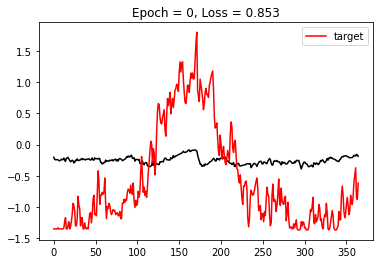

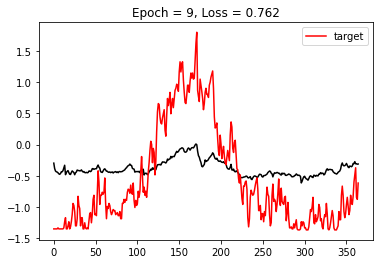

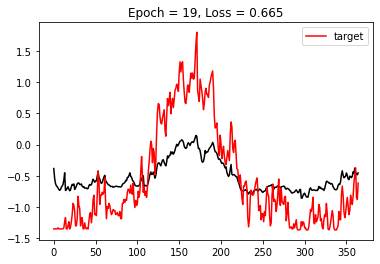

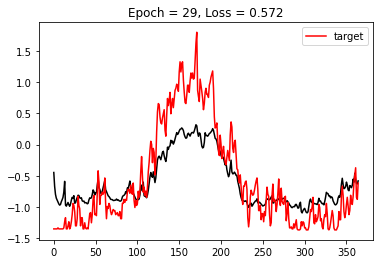

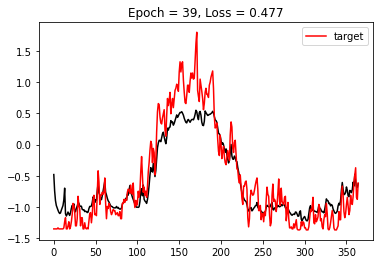

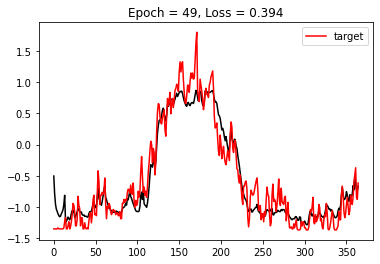

In [6]:
epochs = 50

for i in range(epochs):
    out = model(x)
    loss = loss_fn(y, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % int(epochs/5) == 0 or i == 0:
        plt.plot(out.detach()[1], color = 'black')
        plt.plot(y[1], color = 'red', label = 'target')
        plt.title('Epoch = ' + str(i) + ', Loss = ' + str(np.round(loss.item(), 3)))
        plt.legend()
        plt.pause(0.001);

# Apply XAI and visualize

In [7]:
ig = IntegratedGradients(model)

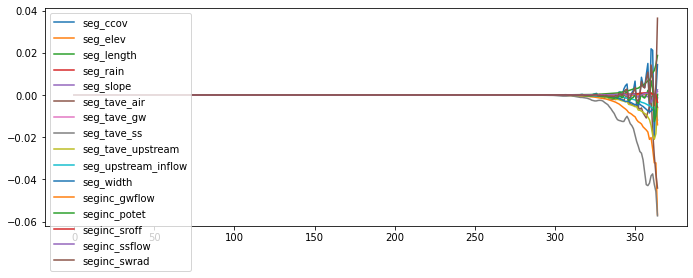

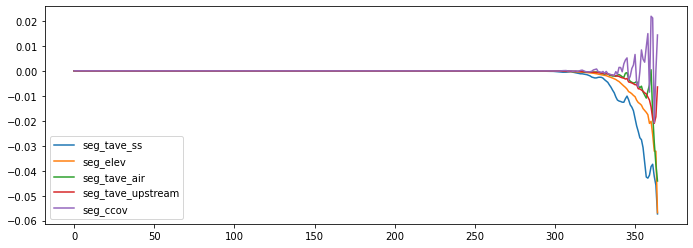

In [8]:
attributions = ig.attribute(x[0:1], n_steps = batch_size, target = -1) # attributions for last day in the sequence

plt.figure(figsize = (11.5, 4))
for i in range(16):
    plt.plot(attributions[0, :, i], label = river_dl['x_vars'][i])
plt.legend(loc = 'upper left')
plt.pause(0.001)

# sort the top vars by IGs (absolute value sum along time series)
biggest_ig = torch.argsort(torch.sum(torch.abs(attributions), dim = 1), descending = True)
biggest_ig = biggest_ig.squeeze()[:5]

plt.figure(figsize = (11.5, 4))
for i in biggest_ig:
    plt.plot(attributions[0, :, i], label = river_dl['x_vars'][i])
plt.legend();

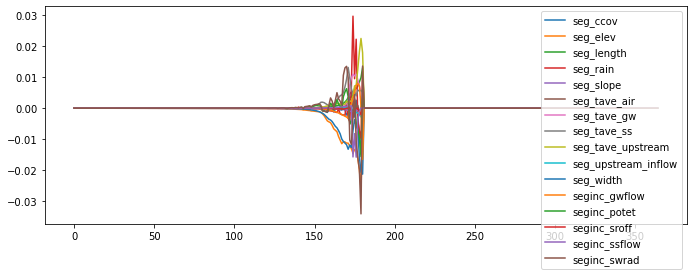

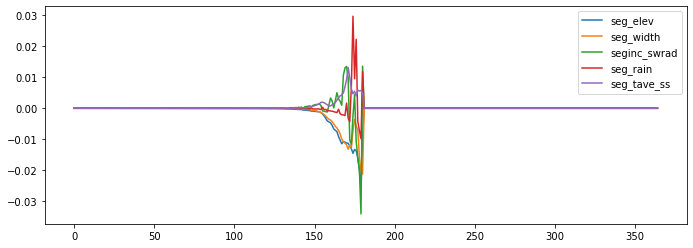

In [9]:
attributions = ig.attribute(x[0:1], n_steps = 455, target = 180) # attributions for 180th day in the sequence

plt.figure(figsize = (11.5, 4))
for i in range(16):
    plt.plot(attributions[0, :, i], label = river_dl['x_vars'][i])
plt.legend()
plt.pause(0.001)

# sort the top vars by IGs (absolute value sum along time series)
biggest_ig = torch.argsort(torch.sum(torch.abs(attributions), dim = 1), descending = True)
biggest_ig = biggest_ig.squeeze()[:5]

plt.figure(figsize = (11.5, 4))
for i in biggest_ig:
    plt.plot(attributions[0, :, i], label = river_dl['x_vars'][i])
plt.legend();

# Provides results, but can we trust it (temporally)?

It seems to suggest that variables more than 2 months out don't matter. So presumably we can change those without consequence...

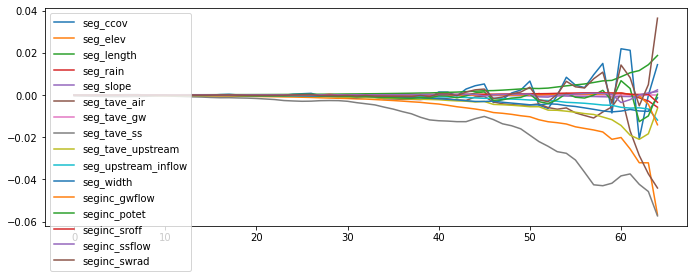

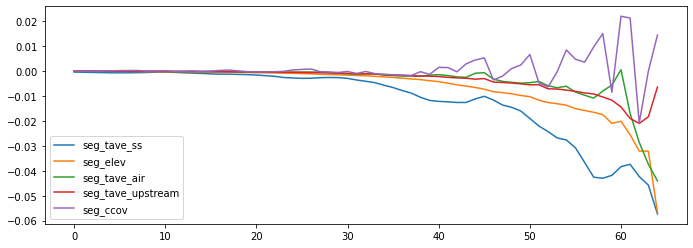

In [10]:
attributions = ig.attribute(x[0:1, -65:], n_steps = batch_size, target = -1) # attributions for last day in the sequence

plt.figure(figsize = (11.5, 4))
for i in range(16):
    plt.plot(attributions[0, -65:, i], label = river_dl['x_vars'][i])
plt.legend(loc = 'upper left')
plt.pause(0.001)

# sort the top vars by IGs (absolute value sum along time series)
biggest_ig = torch.argsort(torch.sum(torch.abs(attributions), dim = 1), descending = True)
biggest_ig = biggest_ig.squeeze()[:5]

plt.figure(figsize = (11.5, 4))
for i in biggest_ig:
    plt.plot(attributions[0, -65:, i], label = river_dl['x_vars'][i])
plt.legend();

That does appear to be the case... Alterations to days 0-300 don't affect day 365's predictions. Alterations closer to the 365-day mark increasingly affect the prediction

In [11]:
def compare_temporally_altered(first_n_days):
    y_hat_original = model(x)

    # replace first n out of 365 days with random values
    # and see how results change
    x_hypothesis = x.detach().clone()
    x_hypothesis[:, :first_n_days] = torch.rand_like(x[:, :first_n_days])
    y_hat_hypothesis = model(x_hypothesis)

    fig, ax = plt.subplots(3, 2, figsize = (12, 9))

    ax[0,0].plot(x[0].detach(), color = 'black', alpha = 0.1)
    ax[0,0].set_ylim(-3, 5)
    ax[0,1].plot(x_hypothesis[0], color = 'black', alpha = 0.1)
    ax[0,1].set_ylim(-3, 5)
    ax[1,0].plot(y_hat_original[0].detach())
    ax[1,0].set_ylim(-1.5, 1.5)
    ax[1,1].plot(y_hat_hypothesis[0].detach())
    ax[1,1].set_ylim(-1.5, 1.5)
    ax[2,0].plot(y_hat_original[0, :].detach())
    ax[2,0].plot(y_hat_hypothesis[0, :].detach())
    ax[2,1].plot(y_hat_original[0, -60:].detach())
    ax[2,1].plot(y_hat_hypothesis[0, -60:].detach());

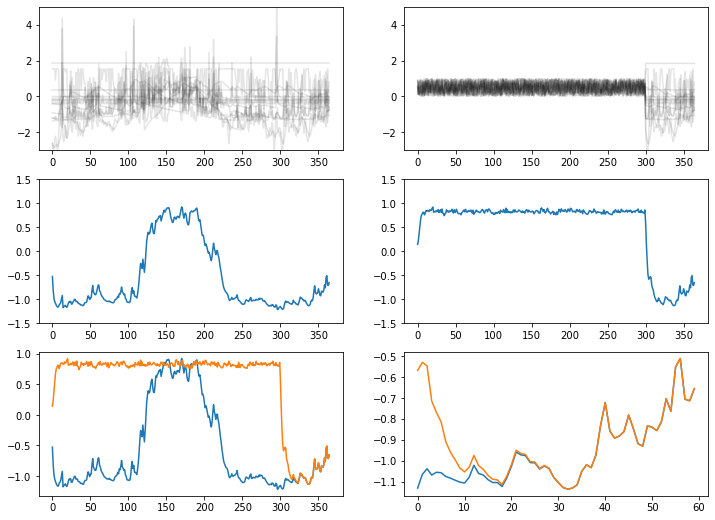

In [12]:
compare_temporally_altered(300)

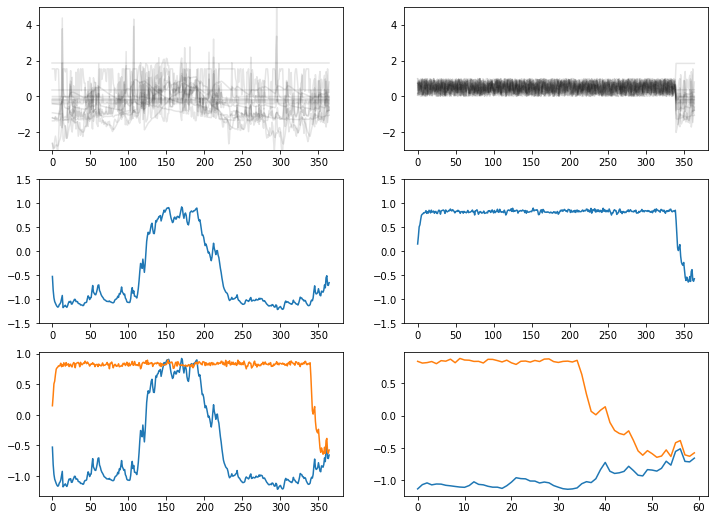

In [13]:
compare_temporally_altered(340)

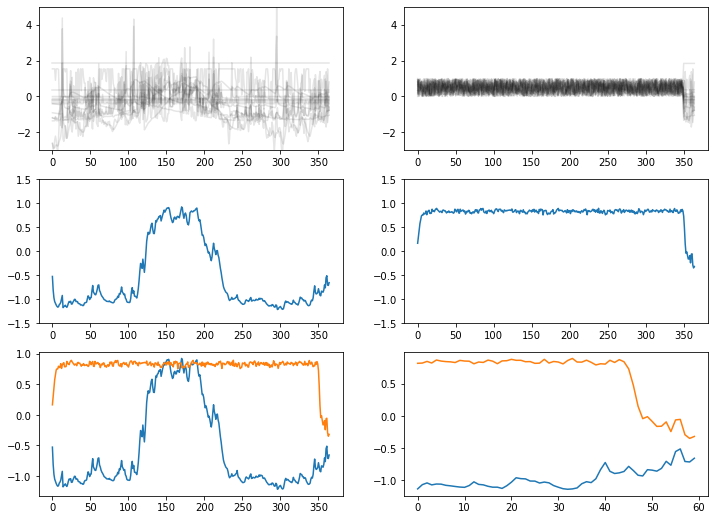

In [14]:
compare_temporally_altered(350)